# BPU: Biological Processing Unit Tutorial

This notebook guides you through using the Drosophila larva connectome as an RNN for image classification on MNIST. We'll cover:

1. Setting up experiment configurations
2. Loading and preprocessing data
3. Training and evaluating models
4. Visualizing results

In [8]:
import os
import sys
import yaml
import torch
import matplotlib.pyplot as plt

# Add the src directory to the path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))

## 1. Configuration Setup

The project uses a YAML configuration file to define experiments. Let's examine the structure and create a simple configuration.

In [12]:
# Load the default config
with open("../config/tutorial_config.yaml", "r") as f:
    config = yaml.safe_load(f)

# Display the global configuration
print("Global Configuration:")
for key, value in {k: v for k, v in config.items() if k != "experiments"}.items():
    print(f"  {key}: {value}")

# Display available experiments
print("\nAvailable Experiments:")
for exp_id in config["experiments"].keys():
    print(f"  - {exp_id}")

Global Configuration:
  annotation_path: ../data/science.add9330_data_s2.csv
  batch_size: 64
  csv_paths: {'signed': '../data/signed_connectivity_matrix.csv', 'unsigned': '../data/ad_connectivity_matrix.csv'}
  fewshot: {'batch_size': 17, 'enabled': True, 'samples': 60}
  learning_rate: 0.001
  num_epochs: 5
  num_trials: 1
  rescale_factor: 0.04
  result_path: ../results
  signed: True
  sio: True

Available Experiments:
  - Unlearnable_DPU


### Creating a Custom Configuration

Let's create a minimal configuration for a simple experiment.

In [14]:
# Create a minimal configuration
minimal_config = {
    "result_path": "../results",
    "signed": True,
    "sio": True,
    "fewshot": {
        "enabled": True,
        "samples": 60,  # 1% of training data
        "batch_size": 17
    },
    "num_trials": 1,
    "num_epochs": 5,
    "batch_size": 64,
    "learning_rate": 0.001,
    "csv_paths": {
        "signed": "../data/signed_connectivity_matrix.csv",
        "unsigned": "../data/ad_connectivity_matrix.csv"
    },
    "annotation_path": "../data/science.add9330_data_s2.csv",
    "rescale_factor": 0.04,
    "experiments": {
        "Unlearnable_DPU": {
            "type": "basicrnn",
            "trainable": False,
            "init": "droso"
        }
    }
}

# Save the configuration to a file for use in training
with open("../config/tutorial_config.yaml", "w") as f:
    yaml.dump(minimal_config, f, default_flow_style=False)

## 2. Loading and Processing the Connectome Data

Let's explore how to load and process the Drosophila connectome data.

In [16]:
from connectome import load_sio_connectivity_data

# Load the connectivity data
conn_data = load_sio_connectivity_data(
    connectivity_path=minimal_config["csv_paths"]["signed"],
    annotation_path=minimal_config["annotation_path"],
    rescale_factor=minimal_config["rescale_factor"],
    normalization="minmax",
    sensory_type="visual"
)

# Display information about the loaded data
print(f"Connectivity matrix shape: {conn_data['W'].shape}")
print(f"Number of sensory neurons: {len(conn_data['sensory_ids'])}")
print(f"Number of internal neurons: {len(conn_data['internal_ids'])}")
print(f"Number of output neurons: {len(conn_data['output_ids'])}")

Annotation file: Found 29 visual sensory neuron IDs
Annotation file: Found 400 output neuron IDs
Connectivity matrix contains 2952 neurons
After filtering, found 29 visual sensory neurons in matrix
After filtering, found 400 output neurons in matrix
Remaining 2523 neurons classified as internal
Connectivity matrix shape: (2952, 2952)
Number of sensory neurons: 29
Number of internal neurons: 2523
Number of output neurons: 400


## 3. Load MNIST Dataset

Next, let's load the MNIST dataset using our DataLoader class.

Training set size: 60000
Test set size: 10000


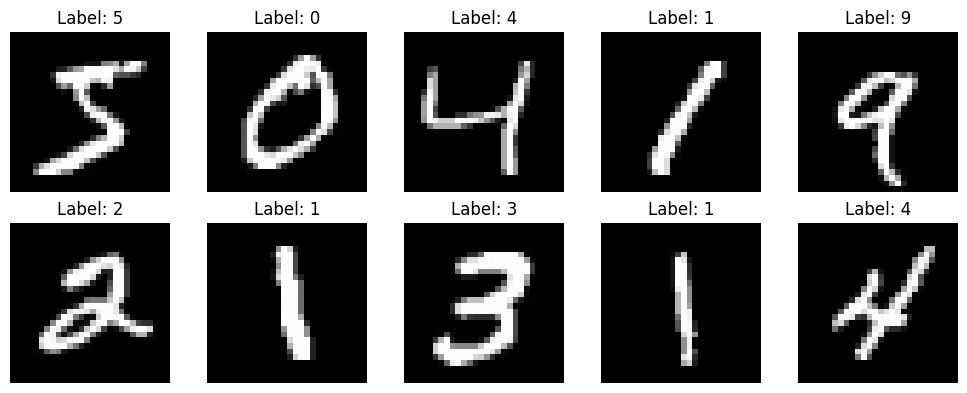

In [5]:
from data_loader import DataLoader

# Create a data loader instance
data_loader = DataLoader(batch_size=minimal_config["batch_size"])

# Load the MNIST dataset
full_train_set, test_loader = data_loader.load_data()

# Display information about the dataset
print(f"Training set size: {len(full_train_set)}")
print(f"Test set size: {len(test_loader.dataset)}")

# Visualize some examples
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    img, label = full_train_set[i]
    ax.imshow(img.squeeze().numpy(), cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')
plt.tight_layout()
plt.show()

## 4. Initialize and Explore the Model

Let's create a model using the Drosophila connectome as initialization.

In [ ]:
from net import BasicRNN
from utils import get_weight_matrix

# Get the weight matrix from the connectome data
W_init = get_weight_matrix(conn_data['W'], "droso")

# Create a BasicRNN model
model = BasicRNN(
    W_init=W_init,
    input_dim=784,  # MNIST image size (28x28)
    sensory_dim=len(conn_data['sensory_ids']),
    internal_dim=len(conn_data['internal_ids']),
    output_dim=len(conn_data['output_ids']),
    num_classes=10,  # 10 digits in MNIST
    trainable=False,  # Keep DPU weights frozen
    pruning=False
)

# Display model architecture
print(model)

# Count parameters
def count_parameters(model):
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    return trainable, total

trainable_params, total_params = count_parameters(model)
print(f"Trainable parameters: {trainable_params:,}")
print(f"Total parameters: {total_params:,}")

BasicRNN init: trainable=False, pruning=False, target_nonzeros=None, lambda_l1=0.0001
LoRA config: use_lora=False, rank=8, alpha=16
W_init.shape: (2952, 2952), sensory_dim: 29, internal_dim: 2523, output_dim: 400
BasicRNN(
  (input_proj): Linear(in_features=784, out_features=29, bias=True)
  (output_layer): Linear(in_features=400, out_features=10, bias=True)
  (activation): ReLU()
)
Trainable parameters: 26,775
Total parameters: 26,775


## 5. Train the Model

Now let's train our model with a few-shot learning setting.

In [28]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define training parameters
num_epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Track metrics
train_losses = []
train_accs = []
test_accs = []

# Evaluate the model before training
def evaluate(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.squeeze(1).to(device)
            target = target.to(device)
            output = model(data)
            correct += output.argmax(dim=1).eq(target).sum().item()
            total += target.size(0)
    return correct / total

# Evaluate initial performance
init_acc = evaluate(model, test_loader)
test_accs.append(init_acc)
print(f"Initial test accuracy: {init_acc:.2%}")

# Training loop
for epoch in range(num_epochs):
    # Create few-shot subset for this epoch
    train_loader = data_loader.get_train_loader(
        full_train_set,
        epoch=epoch,
        fewshot_samples=minimal_config["fewshot"]["samples"],
        fewshot_batch_size=minimal_config["fewshot"]["batch_size"]
    )
    
    # Train one epoch
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False, ncols=80)
    
    for data, target in pbar:
        data = data.squeeze(1).to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * data.size(0)
        correct += output.argmax(dim=1).eq(target).sum().item()
        total += data.size(0)
        
        train_acc = correct / total if total else 0
        pbar.set_postfix(loss=f"{loss.item():.4f}", train_acc=f"{train_acc:.2%}")
    
    epoch_loss = total_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    
    # Evaluate on test set
    test_acc = evaluate(model, test_loader)
    test_accs.append(test_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2%}, Test Acc: {test_acc:.2%}")

# Save model
os.makedirs("../results/models", exist_ok=True)
torch.save(model.state_dict(), "../results/models/tutorial_model.pt")
print("Model saved to ../results/models/tutorial_model.pt")

Initial test accuracy: 11.35%


Epoch 1/5 - Loss: 2.3021, Train Acc: 11.17%, Test Acc: 11.35%


Epoch 2/5 - Loss: 2.3019, Train Acc: 11.17%, Test Acc: 11.35%


Epoch 3/5 - Loss: 2.3019, Train Acc: 11.17%, Test Acc: 11.35%


Epoch 4/5 - Loss: 2.3019, Train Acc: 11.17%, Test Acc: 11.35%


Epoch 5/5 - Loss: 2.3018, Train Acc: 11.17%, Test Acc: 11.35%
Model saved to ../results/models/tutorial_model.pt


## 6. Visualize Training Results

Let's visualize the training progress and analyze the model's performance.

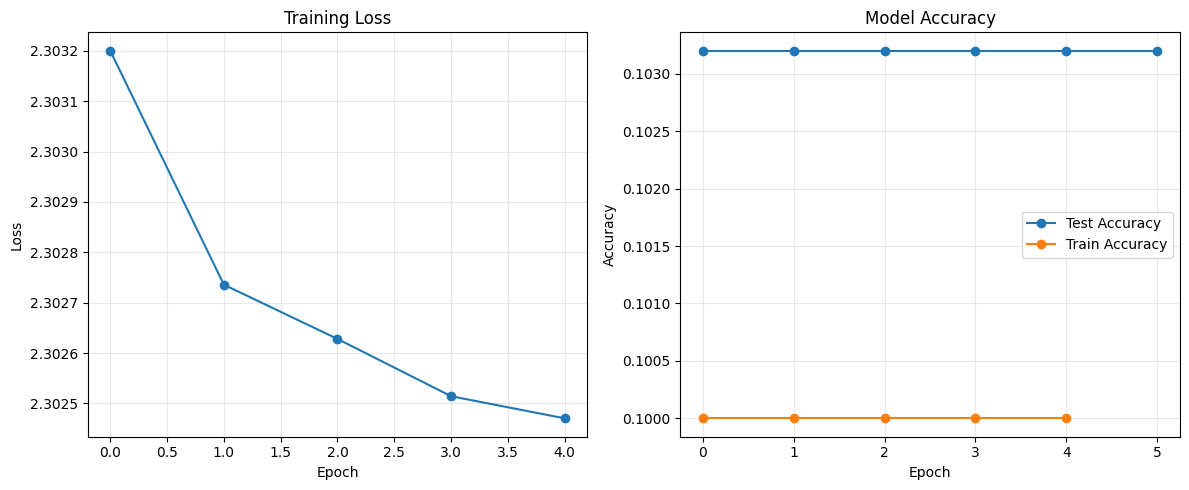

In [21]:
# Plot training metrics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, 'o-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(test_accs, 'o-', label='Test Accuracy')
plt.plot(train_accs, 'o-', label='Train Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Analyze Weight Matrix Changes

Let's analyze how the weight matrix has changed during training (applicable for trainable models).

cosine_similarity: 1.0000
frobenius_diff: 0.0000
relative_frobenius_diff: 0.0000
init_sparsity: 0.9927
effective_sparsity: 0.9927
shared_nonzeros: 0.0073
new_nonzeros: 0.0000


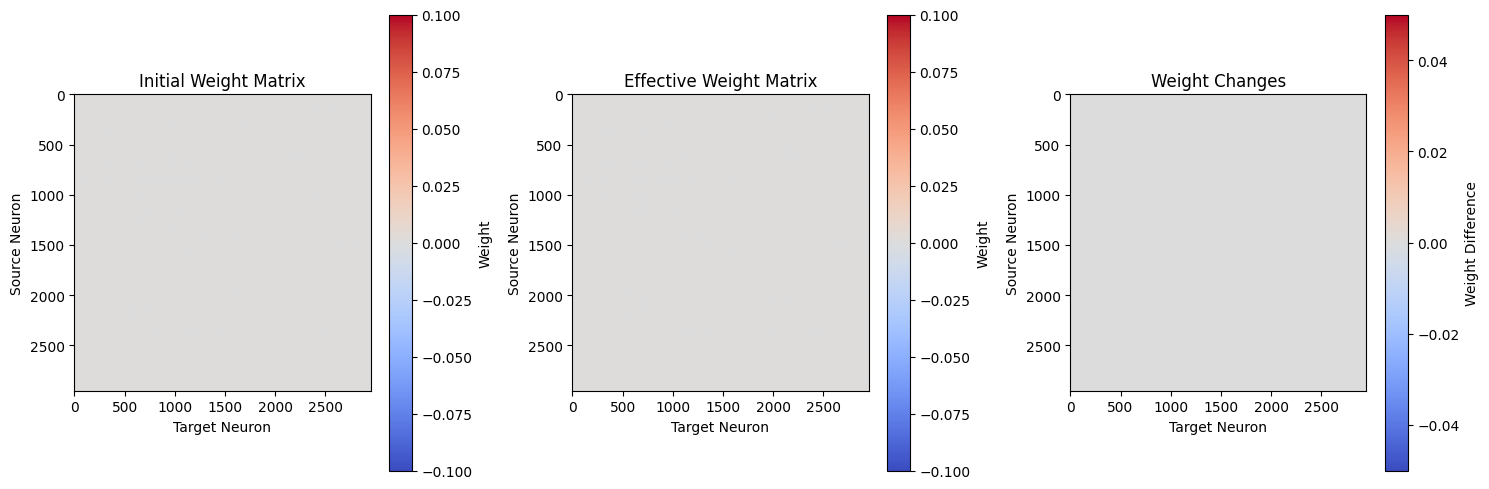

In [22]:
# Get effective weights
W_eff = model.get_effective_W().detach().cpu().numpy()
W_init = model.W_init.detach().cpu().numpy()

# Calculate similarity metrics
similarity_metrics = model.calculate_matrix_similarity()
for metric, value in similarity_metrics.items():
    print(f"{metric}: {value:.4f}")

# Visualize the weight changes
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(W_init, cmap='coolwarm', vmin=-0.1, vmax=0.1)
plt.colorbar(label='Weight')
plt.title('Initial Weight Matrix')
plt.xlabel('Target Neuron')
plt.ylabel('Source Neuron')

plt.subplot(1, 3, 2)
plt.imshow(W_eff, cmap='coolwarm', vmin=-0.1, vmax=0.1)
plt.colorbar(label='Weight')
plt.title('Effective Weight Matrix')
plt.xlabel('Target Neuron')
plt.ylabel('Source Neuron')

plt.subplot(1, 3, 3)
plt.imshow(W_eff - W_init, cmap='coolwarm', vmin=-0.05, vmax=0.05)
plt.colorbar(label='Weight Difference')
plt.title('Weight Changes')
plt.xlabel('Target Neuron')
plt.ylabel('Source Neuron')

plt.tight_layout()
plt.show()

## 8. Visualize Model Predictions

Let's visualize some predictions from the trained model.

Exception ignored in: <function tqdm.__del__ at 0x125879af0>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/rnn_fly_env/lib/python3.9/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/opt/anaconda3/envs/rnn_fly_env/lib/python3.9/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x125879af0>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/rnn_fly_env/lib/python3.9/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/opt/anaconda3/envs/rnn_fly_env/lib/python3.9/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


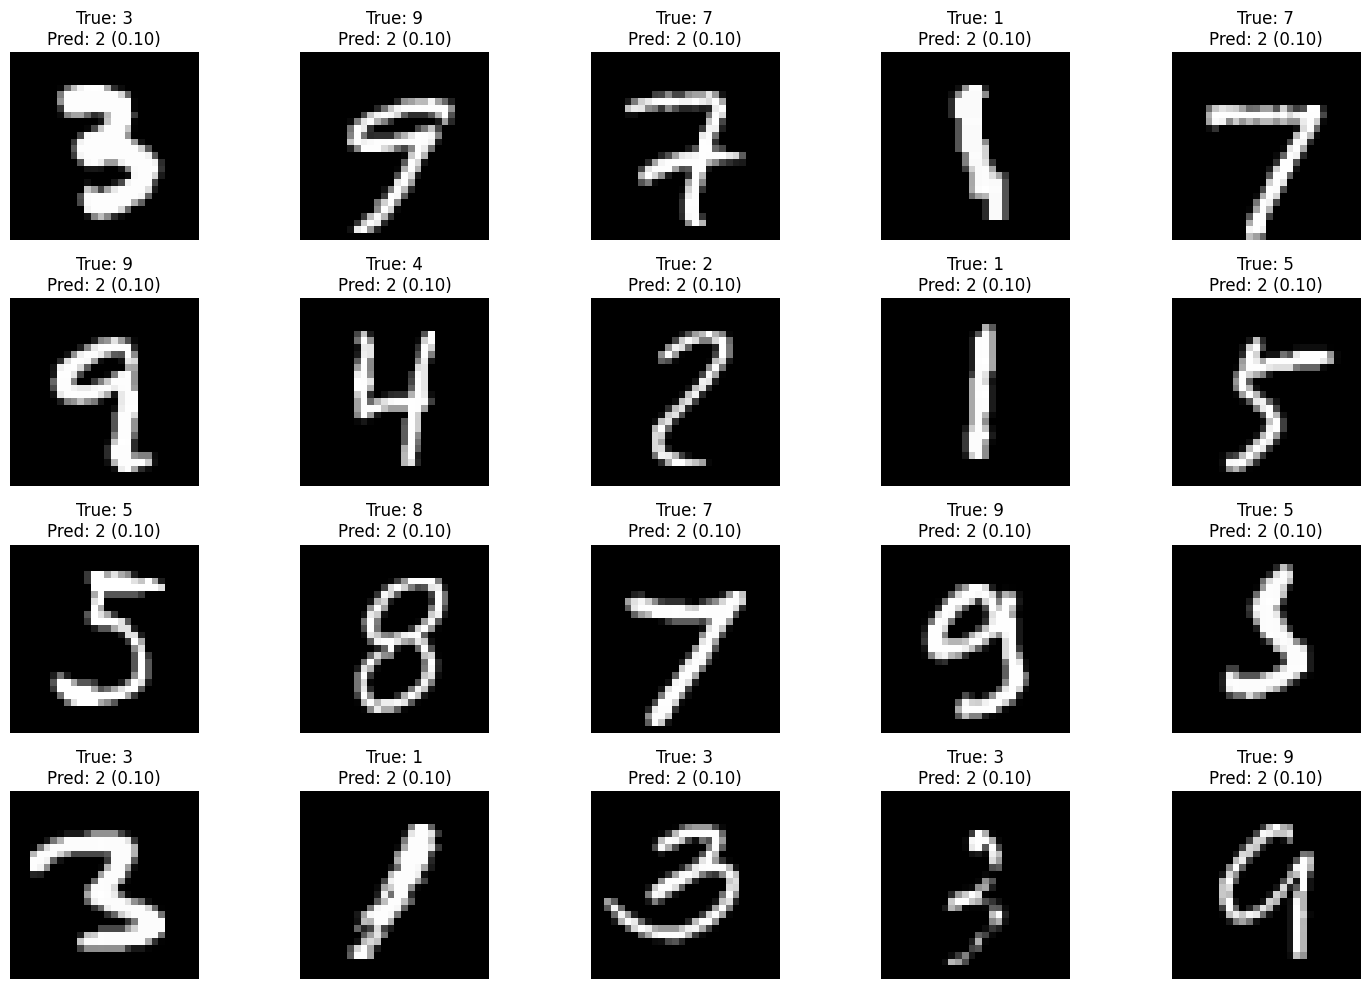

In [23]:
# Get some test samples
test_loader_samples = torch.utils.data.DataLoader(
    test_loader.dataset, batch_size=20, shuffle=True
)
images, labels = next(iter(test_loader_samples))

# Get model predictions
model.eval()
with torch.no_grad():
    images_device = images.squeeze(1).to(device)
    outputs = model(images_device)
    _, predicted = torch.max(outputs, 1)
    probs = torch.nn.functional.softmax(outputs, dim=1)

# Display predictions
fig, axes = plt.subplots(4, 5, figsize=(15, 10))
for i, ax in enumerate(axes.flat):
    if i < len(images):
        img = images[i].squeeze().numpy()
        label = labels[i].item()
        pred = predicted[i].item()
        prob = probs[i, pred].item()
        
        ax.imshow(img, cmap='gray')
        ax.set_title(f'True: {label}\nPred: {pred} ({prob:.2f})')
        
        # Highlight correct/incorrect predictions
        if label == pred:
            ax.spines['bottom'].set_color('green')
            ax.spines['top'].set_color('green')
            ax.spines['left'].set_color('green')
            ax.spines['right'].set_color('green')
            ax.spines['bottom'].set_linewidth(5)
            ax.spines['top'].set_linewidth(5)
            ax.spines['left'].set_linewidth(5)
            ax.spines['right'].set_linewidth(5)
        else:
            ax.spines['bottom'].set_color('red')
            ax.spines['top'].set_color('red')
            ax.spines['left'].set_color('red')
            ax.spines['right'].set_color('red')
            ax.spines['bottom'].set_linewidth(5)
            ax.spines['top'].set_linewidth(5)
            ax.spines['left'].set_linewidth(5)
            ax.spines['right'].set_linewidth(5)
    ax.axis('off')
plt.tight_layout()
plt.show()